<a href="https://colab.research.google.com/github/S-Li/msci-nlp-w22/blob/main/fnc-1/loss_balancing_and_2BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/GitHub

/content/drive/MyDrive/GitHub


In [ ]:
# !git clone https://github.com/FakeNewsChallenge/fnc-1

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 38.7 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

transformers.logging.set_verbosity_error()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%cd /content/drive/MyDrive/GitHub/fnc-1

/content/drive/MyDrive/GitHub/fnc-1


# Experiment 2 - Loss Balancing

In [ ]:
df_stances_train = pd.read_csv("train_stances.csv")
df_stances_comp = pd.read_csv("competition_test_stances.csv")
comp_stances_len = len(df_stances_comp)

In [ ]:
df_body_train = pd.read_csv("train_bodies.csv")
df_body_comp = pd.read_csv("competition_test_bodies.csv")
df_body_comp.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'article stance')

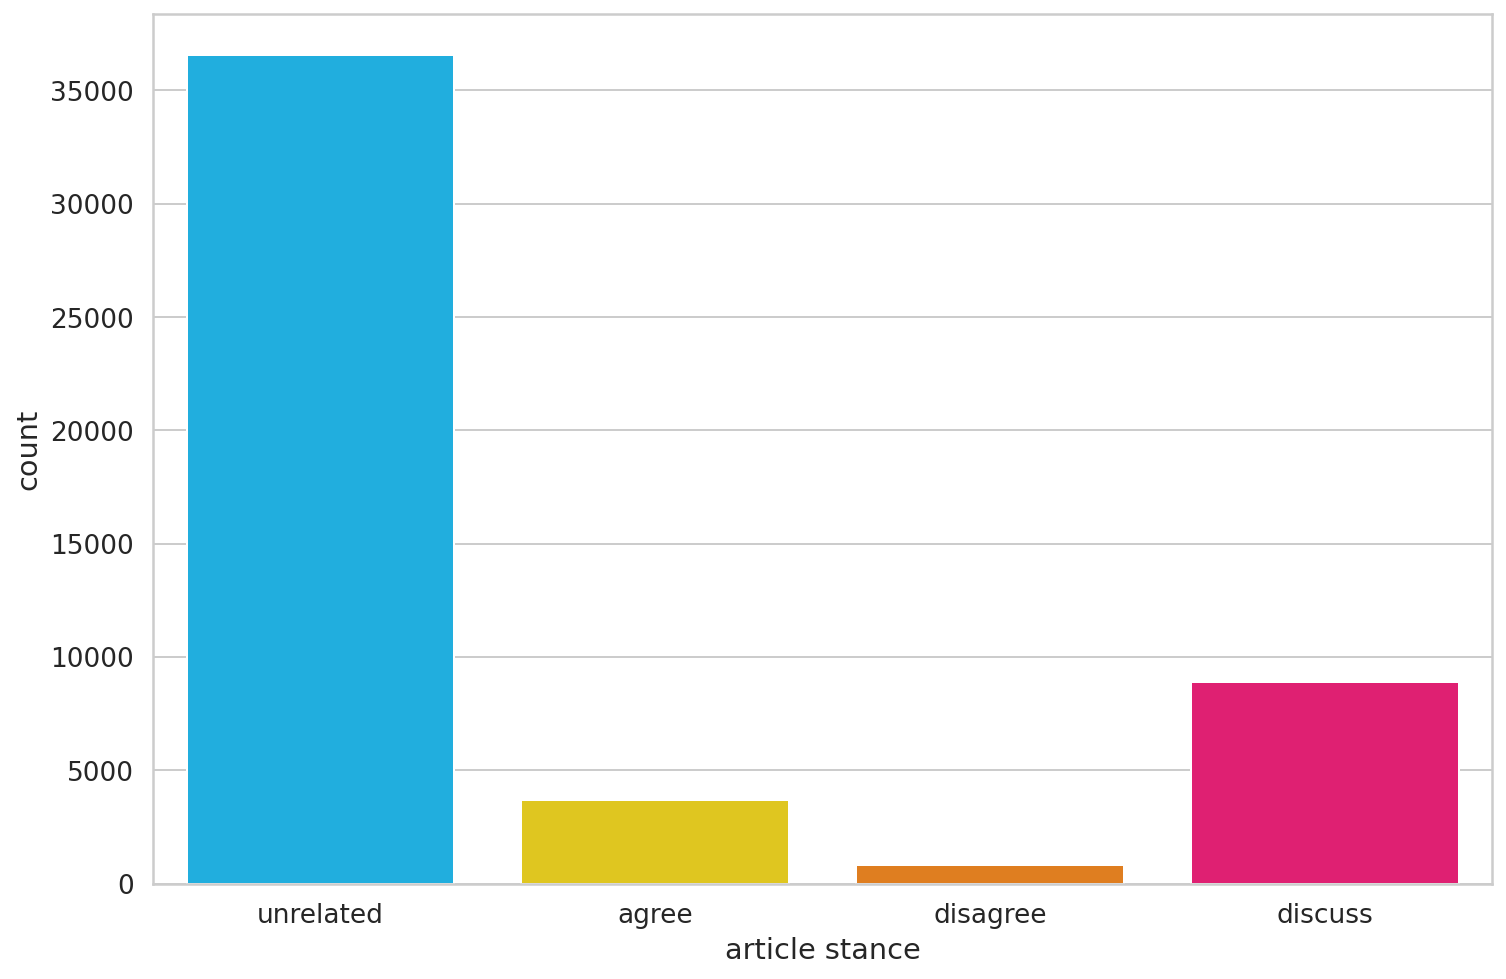

In [ ]:
sns.countplot(df_stances_train.Stance)
plt.xlabel('article stance')

In [ ]:
stances = ['agree', 'disagree', 'discuss', 'unrelated']

Data Preprocessing

In [ ]:
pretrained_model_name = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 250

In [ ]:
class ArticleDataset(Dataset):

  # takes in headlines and bodies from the original corpus
  # just send in the pandas dataframe?
  def __init__(self, headlines, bodies, tokenizer, max_len):
    self.headlines = headlines
    self.bodies = bodies
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.LABELS = ['unrelated','agree', 'disagree', 'discuss',]
  
  # return (number of headlines, number of article bodies)
  def __len__(self):
    return len(self.headlines)
  
  # return the headline, body article, input_ids, attention masks, and label
  def __getitem__(self, item):
    sample_headline = self.headlines.iloc[item,0]
    body_id = self.headlines.iloc[item,1]
    sample_body = self.bodies.loc[self.bodies["Body ID"] == body_id, "articleBody"].item()
    stance = self.LABELS.index(self.headlines.iloc[item, 2])

    encoding = self.tokenizer(
      sample_headline,
      sample_body,
      max_length = max_len,
      padding='max_length',
      truncation = True,
      return_tensors = 'pt',
    )

    return {
      'headline': sample_headline,
      'article_body': sample_body,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stance': torch.tensor(stance)
    }

In [ ]:
batch_size = 16

In [ ]:
# helper function to create a data loader
def create_data_loader(df_s, df_b, tokenizer, max_len, batch_size):
  ds = ArticleDataset(
    headlines = df_s,
    bodies = df_b,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
  )

In [ ]:
train_data_loader = create_data_loader(df_stances_train, df_body_train, tokenizer, max_len, batch_size)
comp_data_loader = create_data_loader(df_stances_comp, df_body_comp, tokenizer, max_len, batch_size)

In [ ]:
class StanceClassifier(nn.Module):

  def __init__(self, n_classes):
    super(StanceClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    X = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
    )
  
    output = self.drop(X[1])
    return self.out(output)

In [ ]:
model = StanceClassifier(4)
model = model.to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [ ]:
# training
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

class_weights = torch.tensor([3.125, 15.625, 1.388, 0.357])
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# helper function for training model for one epoch
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i, d in enumerate(data_loader):
    print(f"Batch: {i}")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    stance = d["stance"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stance)

    correct_predictions += torch.sum(preds == stance)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for i,d in enumerate(data_loader):
      print(f"Batch: {i}")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stance)

      correct_predictions += torch.sum(preds == stance)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_stances_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
  torch.save(model.state_dict(), 'loss_balance.bin')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

In [ ]:
test_acc, _ = eval_model(
  model,
  comp_data_loader,
  loss_fn,
  device,
  len(df_stances_comp)
)

test_acc.item()

In [ ]:
# helper function to get predictions - similar to evaluation but storing
# review texts and probabilities
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      headlines = d["headline"]
      article = d["article_body"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(stance)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  comp_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=stances))

              precision    recall  f1-score   support

       agree       0.48      0.66      0.56       984
    disagree       0.31      0.08      0.12       382
     discuss       0.75      0.74      0.74      2223
   unrelated       0.98      0.97      0.98      9118

    accuracy                           0.88     12707
   macro avg       0.63      0.61      0.60     12707
weighted avg       0.88      0.88      0.88     12707



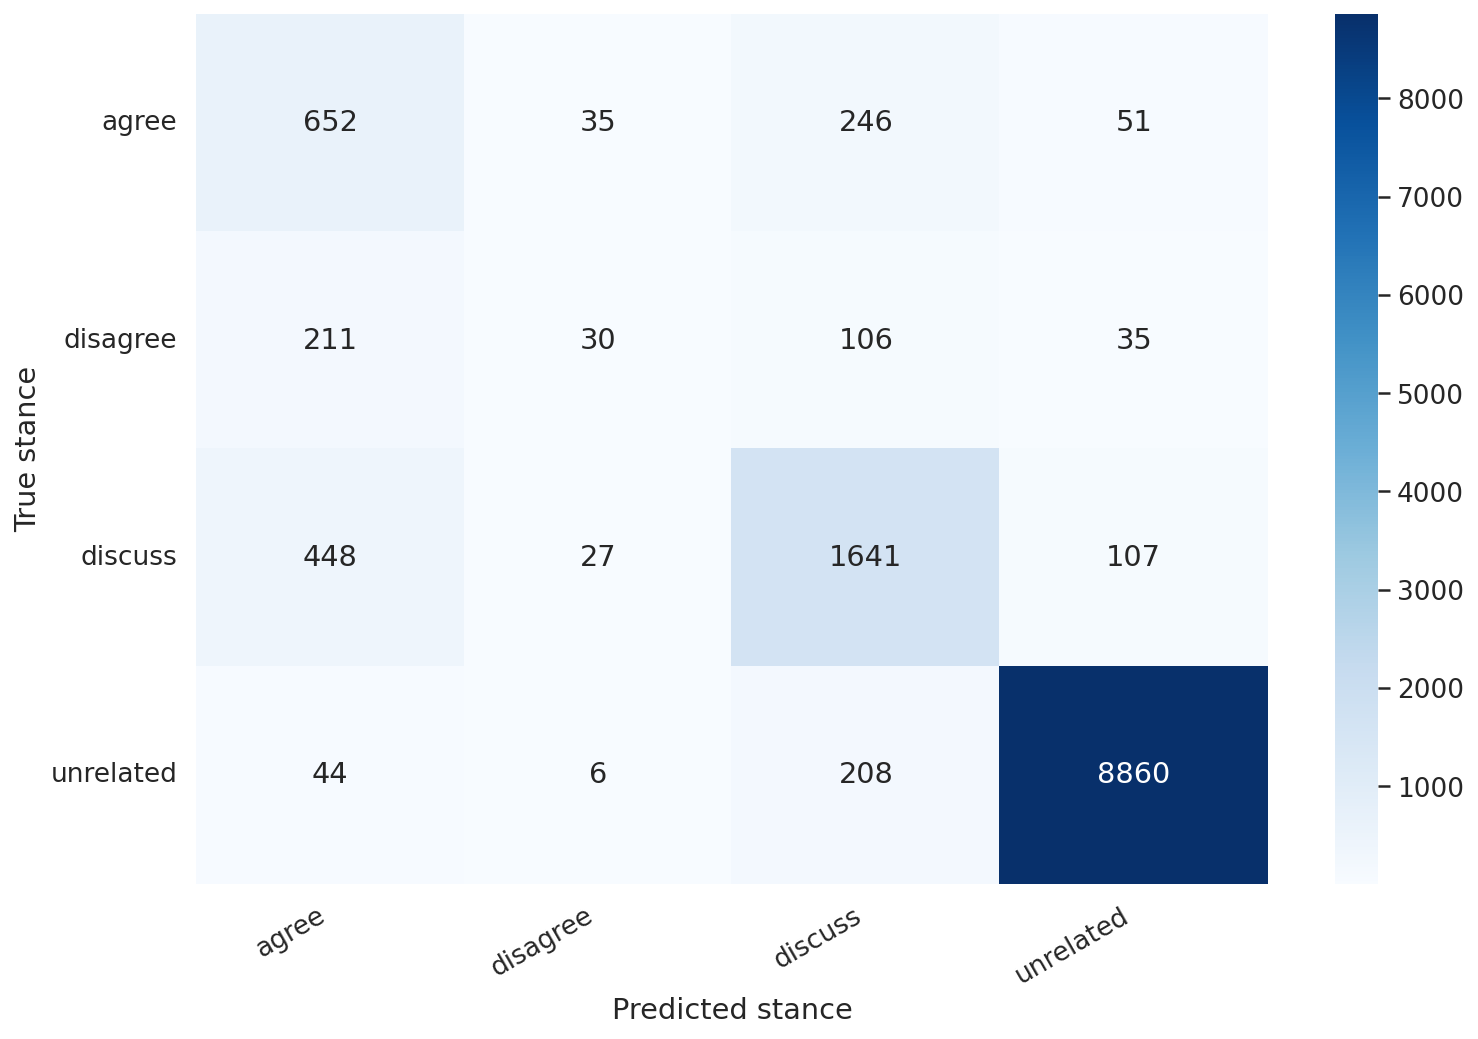

In [ ]:
# confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=stances, columns=stances)
show_confusion_matrix(df_cm)

# Combining 2 BERT models into Ensemble

In [ ]:
# Prediction function for combining the 2 BERT model
def get_predictions_2bert(model_bin, model_ter, data_loader):
  model_bin = model_bin.eval()
  model_ter = model_ter.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      headlines = d["headline"]
      article = d["article_body"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs_bin = model_bin(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      outputs_ter = model_ter(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds_bin = torch.max(outputs_bin, dim=1)
      _, preds_ter = torch.max(outputs_ter, dim=1)

      preds = preds_bin * (preds_ter + 1)

      # print(preds)
      # print(stance)
      # print("\n")
      # probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      real_values.extend(stance)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

In [ ]:
model_bin = StanceClassifier(2)
model_bin = model_bin.to(device)
model_bin.load_state_dict(torch.load("trial-3_binary_best_model_state.bin"))

# model_ter = StanceClassifier(3)
# model_ter = model_ter.to(device)
# model_ter.load_state_dict(torch.load("trial-8_last_model_state.bin"))


<All keys matched successfully>

In [ ]:
model_ter = StanceClassifier(3)
model_ter = model_ter.to(device)
checkpoint = torch.load("trial-8_last_model_state.bin")
model_ter.load_state_dict(checkpoint['state_dict'])
# model_ter.load_state_dict(torch.load("trial-8_last_model_state.bin"))

<All keys matched successfully>

In [ ]:
y_pred, y_test = get_predictions_2bert(
  model_bin,
  model_ter,
  comp_data_loader
)

In [ ]:
stances=['unrelated', 'agree', 'disagree', 'discuss']

In [ ]:
print(classification_report(y_test, y_pred, target_names=stances))

              precision    recall  f1-score   support

   unrelated       0.98      0.99      0.98      9118
       agree       0.56      0.72      0.63       984
    disagree       0.45      0.07      0.11       382
     discuss       0.83      0.81      0.82      2223

    accuracy                           0.91     12707
   macro avg       0.70      0.65      0.64     12707
weighted avg       0.90      0.91      0.90     12707



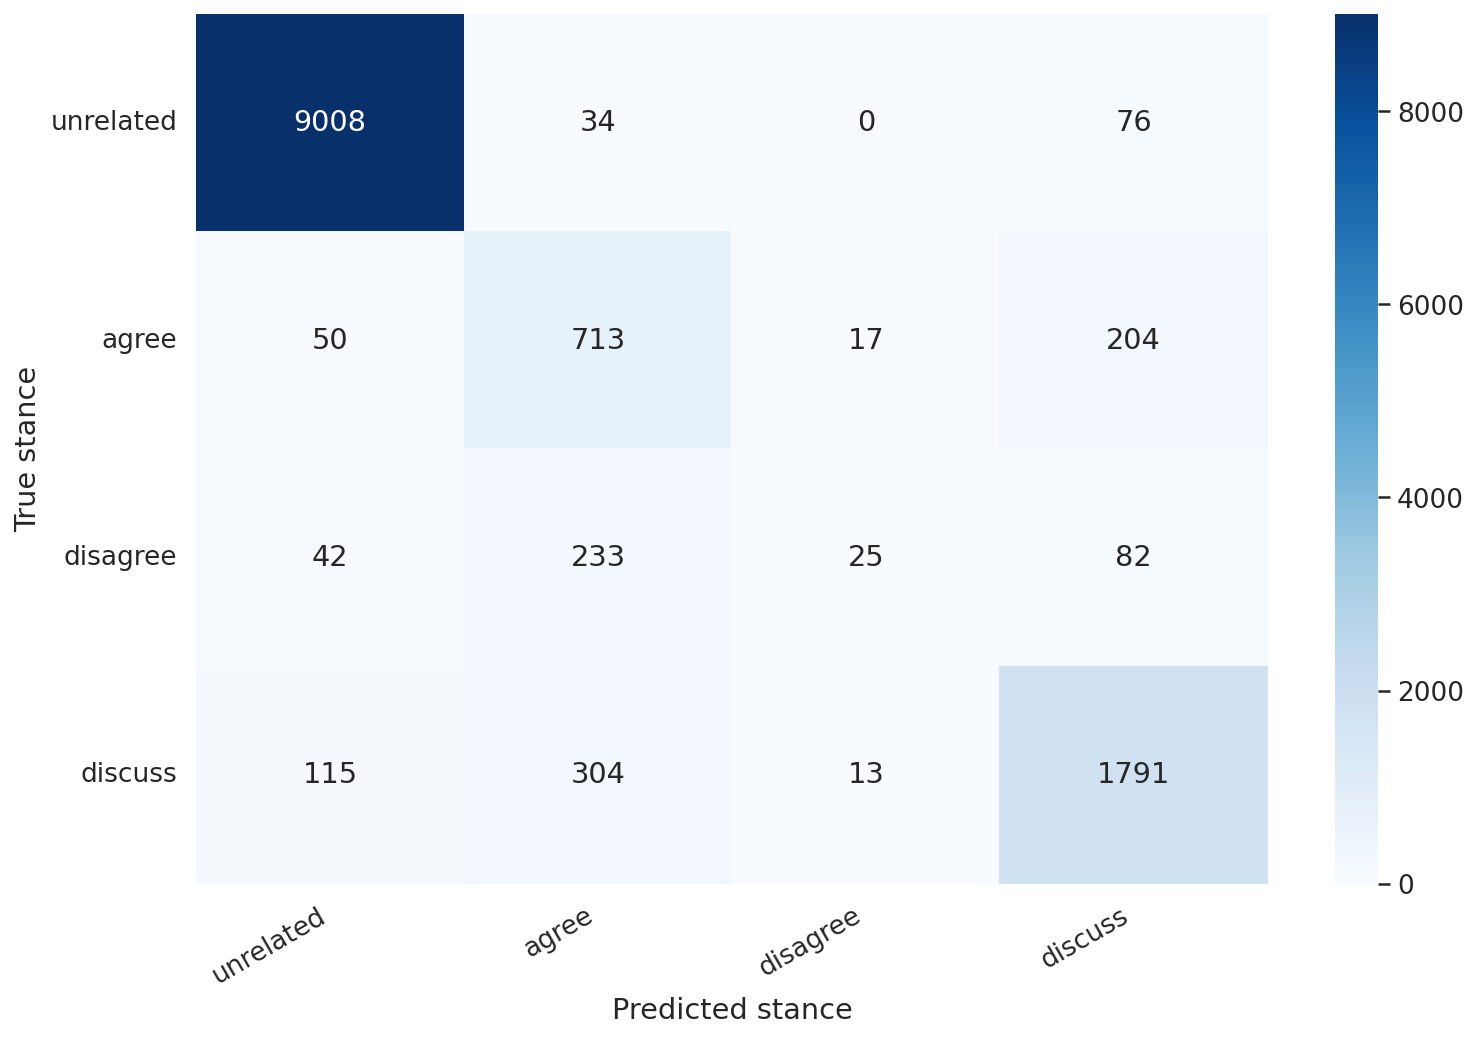

In [ ]:
# confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=stances, columns=stances)
show_confusion_matrix(df_cm)

In [ ]:
y_pred, y_test = get_predictions_2bert(
  model_bin,
  model_ter,
  comp_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=stances))

              precision    recall  f1-score   support

   unrelated       0.98      0.99      0.98     18349
       agree       0.55      0.72      0.62      1903
    disagree       0.48      0.09      0.15       697
     discuss       0.84      0.80      0.82      4464

    accuracy                           0.91     25413
   macro avg       0.71      0.65      0.64     25413
weighted avg       0.91      0.91      0.90     25413



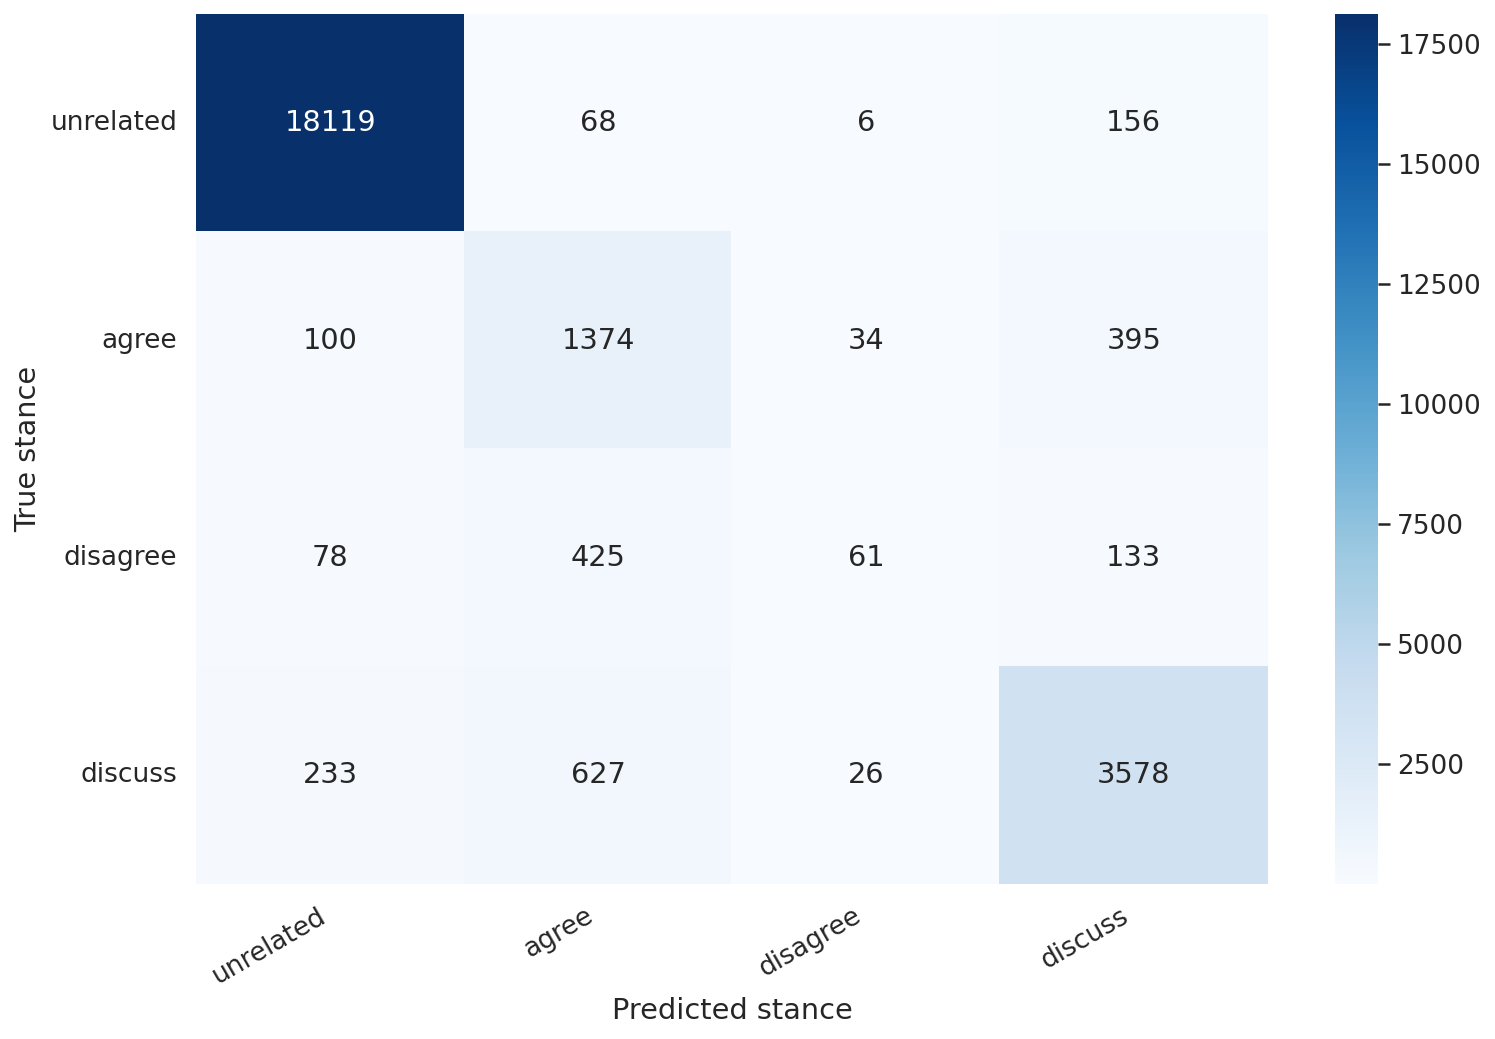

In [ ]:
# confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=stances, columns=stances)
show_confusion_matrix(df_cm)

In [ ]:
y_pred_word = torch.clone(y_pred).tolist()

In [ ]:
for i, stance in enumerate(y_pred_word):
  y_pred_word[i] = stances[stance]

In [ ]:
df_pred = df_stances_comp.copy()

In [ ]:
df_pred['Stance'] = y_pred_word

In [ ]:
df_pred.to_csv("answers.csv", index=False)

In [ ]:
!python scorer.py "competition_test_stances.csv" "answers.csv"

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |   1374    |    34     |    395    |    100    |
-------------------------------------------------------------
| disagree  |    425    |    61     |    133    |    78     |
-------------------------------------------------------------
|  discuss  |    627    |    26     |   3578    |    233    |
-------------------------------------------------------------
| unrelated |    68     |     6     |    156    |   18119   |
-------------------------------------------------------------
ACCURACY: 0.910

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  9952.75  ||

